[https://github.com/NikosNtigas/Rock-Paper-Scissors-RL](https://github.com/NikosNtigas/Rock-Paper-Scissors-RL)

In [1]:
import time
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import ray
import cv2
import gymnasium as gym
import tensorflow as tf

from gymnasium.core import ObsType, ActType
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.models.tf import TFModelV2

In [2]:
class RockPaperScissorsEnv(gym.Env):
    def __init__(self, env_config=None):
        """
        Initializes the RockPaperScissors environment with a given configuration.

        :param env_config: The configuration of the environment. 
        'train': (Default True) A boolean indicating whether the environment should operate in training mode.
        In training mode, the environment uses the training dataset to present observations to the agent.
        'dataset_path': (Default 'rps_dataset.npz') A string specifying the path to the dataset file.
        The file is expected to be a NumPy file with specific keys for training and testing data. See load_data
        'p_ver': (Default 0.5) A float between 0.0 and 1.0 indicating the probability of
        vertically flipping the observation image.
        'p_hor': (Default 0.5) A float between 0.0 and 1.0 indicating the probability of
        horizontally flipping the observation image.
        """
        if env_config is None or env_config == {}:
            env_config = {
                'train': True,
                'dataset_path': 'rps_dataset.npz',
                'p_ver': 0.5,
                'p_hor': 0.5,
            }
        self._p_ver, self._p_hor = env_config['p_ver'], env_config['p_hor']
        self._images, self._gestures = self.load_data(env_config['train'], env_config['dataset_path'])
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(40, 60, 3,),
            dtype=np.float32
        )

        self._steps = 0
        self._current_image = None
        self._current_gesture = None

    @staticmethod
    def load_data(training, path):
        """
        Loads the dataset from the specified file and returns the appropriate set for training or evaluation.
        
        :param training: A boolean flag indicating whether to load the training set (True) or the testing set (False).
        :param path: A string representing the file path to the dataset.
        The file should be a .npz file containing 'x_train', 'y_train' for the training set and 'x_test', 'y_test' for the testing set.
        :return: A tuple of numpy arrays: the first element is the array of images, and the second element is the corresponding array of labels for the gestures.
        The shapes of the arrays should match, ensuring that each image has a corresponding label.
"""
        dataset = np.load(path)
        if training:
            assert len(dataset['x_train']) == len(dataset['y_train']), "x_train and y_train must be of the same length"
            return dataset['x_train'], dataset['y_train']
        assert len(dataset['x_test']) == len(dataset['y_test']), "x_test and y_test must be of the same length"
        return dataset['x_test'], dataset['y_test']

    @staticmethod
    def preprocess_image(image, p_ver, p_hor):
        """
        Preprocesses the input image by applying random vertical and/or horizontal flips based on the provided probabilities and adds Gaussian noise to the image.
        
        :param image: A numpy array representing the image to be preprocessed.
        :param p_ver: A float representing the probability with which to vertically flip the image. Must be between 0.0 and 1.0.
        :param p_hor: A float representing the probability with which to horizontally flip the image. Must be between 0.0 and 1.0.
        :return: A preprocessed image numpy array with the same dimensions as the input image. The pixel values are clipped to be between 0 and 1.
        """
        pre_image = image.copy()
        if np.random.random() < p_ver:
            pre_image = cv2.flip(pre_image, 0)
        if np.random.random() < p_hor:
            pre_image = cv2.flip(pre_image, 1)
        pre_image = pre_image + np.random.normal(loc=0, scale=0.05, size=pre_image.shape)
        pre_image = np.clip(pre_image, 0.0, 1.0)
        return pre_image

    def _get_random_image(self):
        """
        Selects a random image from the environment's dataset and applies preprocessing.
        
        :return: A tuple containing the preprocessed image and its corresponding label.
        The image is randomly selected from the dataset, and preprocessing includes random flips and noise addition.
        """
        rnd_idx = np.random.randint(0, len(self._images) - 1)
        rnd_img = self.preprocess_image(self._images[rnd_idx], self._p_ver, self._p_hor)
        rnd_label = self._gestures[rnd_idx]
        return rnd_img, rnd_label

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None, ) -> Tuple[ObsType, dict]:
        """
        Resets the environment to a new episode. This is typically called at the beginning of an episode.
        
        :return: A tuple where the first element is the initial observation after the reset, which is a preprocessed image of the current gesture,
        and the second element is an empty dictionary that can be used to include additional information.
        """
        self._steps = 0
        self._current_image, self._current_gesture = self._get_random_image()
        return self._current_image, {}

    @staticmethod
    def get_reward(agent_gesture, opponent_gesture):
        """
        Calculates the reward for the agent's action based on the classic rules of Rock-Paper-Scissors.
        
        :param agent_gesture: An integer representing the agent's gesture (0: rock, 1: paper, 2: scissors).
        :param opponent_gesture: An integer representing the opponent's gesture (0: rock, 1: paper, 2: scissors).
        :return: An integer reward value. The agent receives a reward of 1 for winning, 0 for a tie, and -1 for losing the round.
        """
        if agent_gesture == opponent_gesture:
            return 0
        if agent_gesture == 0 and opponent_gesture == 1:
            return -1
        if agent_gesture == 0 and opponent_gesture == 2:
            return 1
        if agent_gesture == 1 and opponent_gesture == 0:
            return 1
        if agent_gesture == 1 and opponent_gesture == 2:
            return -1
        if agent_gesture == 2 and opponent_gesture == 0:
            return -1
        if agent_gesture == 2 and opponent_gesture == 1:
            return 1
        assert f"Invalid action {agent_gesture}, opponent_gesture {opponent_gesture}"

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, dict]:
        """
        Performs an action in the environment and updates the state.
        
        :param action: An integer representing the action to be taken by the agent. It corresponds to the agent's chosen gesture (0: rock, 1: paper, 2: scissors).
        :return: A tuple containing:
            - observation: The next state observation after the action is taken, which is a preprocessed image of a hand gesture.
            - reward: A float indicating the reward received from taking the action.
            - terminated: A boolean indicating if the episode has ended. In this environment, it is always False as episodes do not have a natural end.
            - truncated: A boolean indicating if the episode was truncated, which is always True in this environment because the termination condition is not defined.
            - info: A dictionary that may contain auxiliary diagnostic information (not used in this case).
        """
        reward = self.get_reward(action, self._current_gesture)
        self._current_image, self._current_gesture = self._get_random_image()
        observation = self._current_image.copy()
        terminated = False
        truncated = True
        self._steps += 1
        info = {}
        return observation, reward, terminated, truncated, info

In [3]:
ray.rllib.utils.check_env(RockPaperScissorsEnv())

2024-01-04 04:32:51,763	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2024-01-04 04:32:51,765	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


-1


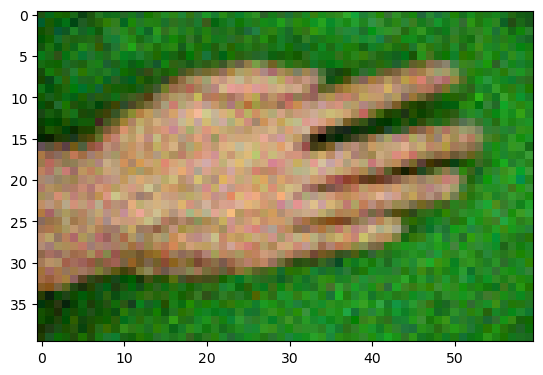

In [4]:
env = RockPaperScissorsEnv()
obs, _ = env.reset()
plt.imshow(obs)
_, reward, _, _, _ = env.step(0)
print(reward)

In [5]:
class ActorCritic(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        image_inputs = tf.keras.layers.Input(shape=obs_space.shape, name='image')

        h_image = tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, activation='relu')(image_inputs)
        h_image = tf.keras.layers.AveragePooling2D()(h_image)
        h_image = tf.keras.layers.BatchNormalization()(h_image)
        h_image = tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, activation='relu')(h_image)
        h_image = tf.keras.layers.AveragePooling2D()(h_image)
        h_image = tf.keras.layers.BatchNormalization()(h_image)
        h_image = tf.keras.layers.Flatten()(h_image)

        x = tf.keras.layers.Dense(units=128, activation='relu')(h_image)

        policy_out = tf.keras.layers.Dense(units=num_outputs, activation=None, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, activation=None, name='value_out')(x)

        self.base_model = tf.keras.Model(
            inputs=[image_inputs],
            outputs=[policy_out, value_out],
            name='base_model'
        )

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict['obs'])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

# model = ActorCritic(obs_space=np.zeros(shape=(40, 60, 3)), action_space=3, num_outputs=3, model_config={}, name='test')
# model.base_model.summary(expand_nested=True)

In [6]:
ray.shutdown()
ray.init()

ModelCatalog.register_custom_model('my_cnn', ActorCritic)

config = (
    PPOConfig()
    .training(
        use_critic=True,
        use_gae=True,
        lambda_=0.2,
        sgd_minibatch_size=64,
        num_sgd_iter=20,
        shuffle_sequences=True,
        vf_loss_coeff=0.5,
        entropy_coeff=0.001,
        clip_param=0.1,
        kl_target=0.1,
        model={
            'vf_share_layers': True,
            "custom_model": 'my_cnn'
        },
        train_batch_size=1024,
        lr=0.0001,
        gamma=0,
    )
    .resources(num_gpus=1)
    .environment(env=RockPaperScissorsEnv, env_config={}, render_env=False)
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1, batch_mode='truncate_episodes')
    .framework(framework='tf2', eager_tracing=True)
)

agent = config.build()
agent.get_policy().model.base_model.summary(expand_nested=True)

2024-01-04 04:32:54,978	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2024-01-04 04:32:58,358	INFO algorithm_config.py:2888 -- Executing eagerly (framework='tf2'), with eager_tracing=tf2. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2024-01-04 04:32:58,397	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=31508) 2024-01-04 04:33:05,437	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=31508) 2024-01-04 04:33:05,437	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. 

Model: "base_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 40, 60, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 36, 56, 64)   4864        ['image[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 18, 28, 64)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, 18, 28, 64)  256         ['average_pooling2d[0][0

In [7]:
train_iterations = 100
avg_train_rew_per_iter = []
avg_eval_rew_per_iter = []

dataset = np.load('rps_dataset.npz')
x_train, y_train = dataset['x_train'], dataset['y_train']
x_test, y_test = dataset['x_test'], dataset['y_test']

for i in range(train_iterations):
    start = time.time()
    log = agent.train()
    end = time.time()
    avg_train_rew_per_iter.append(log['sampler_results']['episode_reward_mean'])

    print(f'Iteration: {i}, '
          f'Elapsed: {(end - start):.2f}, '
          f'Average Rewards: {avg_train_rew_per_iter[-1]:.6f}')

    reward = 0
    for j in range(x_test.shape[0]):
        action = agent.compute_single_action(RockPaperScissorsEnv.preprocess_image(x_test[j], 0.5, 0.5))
        reward += RockPaperScissorsEnv.get_reward(action, y_test[j])
    print(f'Evaluation Reward: {reward}, '
          f'Max Reward: {x_test.shape[0]}, '
          f'Average Reward: {(reward / x_test.shape[0]):.6f}')
    avg_eval_rew_per_iter.append(reward / x_test.shape[0])

np.savez('results.npz', train=avg_train_rew_per_iter, eval=avg_eval_rew_per_iter)

2024-01-04 04:33:28,190	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
2024-01-04 04:33:28,238	WARNING tf_utils.py:576 -- KL divergence is non-finite, this will likely destabilize your model and the training process. Action(s) in a specific state have near-zero probability. This can happen naturally in deterministic environments where the optimal policy has zero mass for a specific action. To fix this issue, consider setting the coefficient for the KL loss term to zero or increasing policy entropy.
2024-01-04 04:33:28,452	WARNING tf_utils.py:576 -- KL divergence is non-finite, this will likely destabilize your model and the training process. Action(s) in a specific state have near-zero probability. This can happen naturally in deterministic environments where the optimal policy has zero mass for a specific action. To fix this issue, consider setting the coefficient for the KL loss term to zero or increa

Iteration: 0, Elapsed: 86.48, Average Rewards: 0.023438
Evaluation Reward: 95, Max Reward: 657, Average Reward: 0.144597
Iteration: 1, Elapsed: 77.55, Average Rewards: 0.126953
Evaluation Reward: 180, Max Reward: 657, Average Reward: 0.273973
Iteration: 2, Elapsed: 76.94, Average Rewards: 0.275391
Evaluation Reward: 287, Max Reward: 657, Average Reward: 0.436834
Iteration: 3, Elapsed: 77.92, Average Rewards: 0.499023
Evaluation Reward: 427, Max Reward: 657, Average Reward: 0.649924
Iteration: 4, Elapsed: 78.67, Average Rewards: 0.672852
Evaluation Reward: 516, Max Reward: 657, Average Reward: 0.785388
Iteration: 5, Elapsed: 77.72, Average Rewards: 0.834961
Evaluation Reward: 566, Max Reward: 657, Average Reward: 0.861492
Iteration: 6, Elapsed: 77.88, Average Rewards: 0.895508
Evaluation Reward: 580, Max Reward: 657, Average Reward: 0.882801
Iteration: 7, Elapsed: 77.70, Average Rewards: 0.883789
Evaluation Reward: 596, Max Reward: 657, Average Reward: 0.907154
Iteration: 8, Elapsed: 77

In [8]:
results = np.load('results.npz')
avg_train_rew_per_iter = np.array(results['train'])
avg_eval_rew_per_iter = np.array(results['eval'])

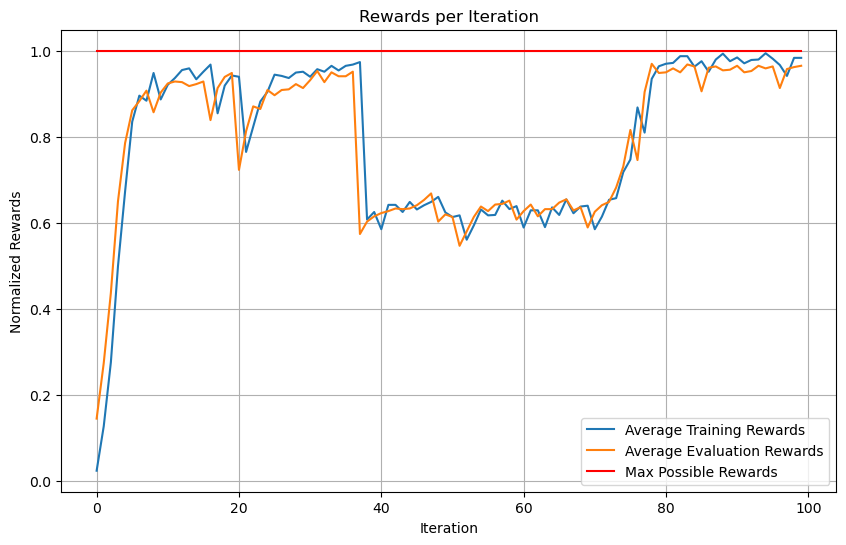

In [9]:
max_possible_rewards = np.full(len(avg_train_rew_per_iter), 1)

plt.figure(figsize=(10, 6))
plt.plot(avg_train_rew_per_iter, label='Average Training Rewards')
plt.plot(avg_eval_rew_per_iter, label='Average Evaluation Rewards')
plt.plot(max_possible_rewards, label='Max Possible Rewards', linestyle='-', color='red')
plt.title('Rewards per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.grid(True)
plt.show()

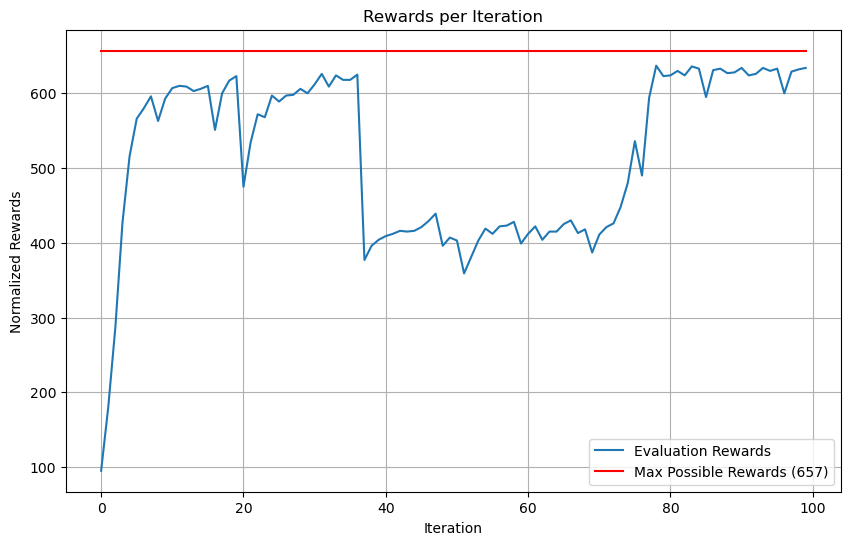

In [10]:
max_possible_rewards = np.full(len(avg_eval_rew_per_iter), x_test.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(avg_eval_rew_per_iter * x_test.shape[0], label='Evaluation Rewards')
plt.plot(max_possible_rewards, label=f'Max Possible Rewards ({x_test.shape[0]})', linestyle='-', color='red')
plt.title('Rewards per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
wins_idx = []
ties_idx = []
loses_idx = []

for j in range(x_test.shape[0]):
    action = agent.compute_single_action(RockPaperScissorsEnv.preprocess_image(x_test[j], 0.5, 0.5))
    reward = RockPaperScissorsEnv.get_reward(action, y_test[j])
    if reward == 1:
        wins_idx.append(j)
    elif reward == 0:
        ties_idx.append(j)
    elif reward == -1:
        loses_idx.append(j)

len(wins_idx), len(ties_idx), len(loses_idx)

(640, 7, 10)

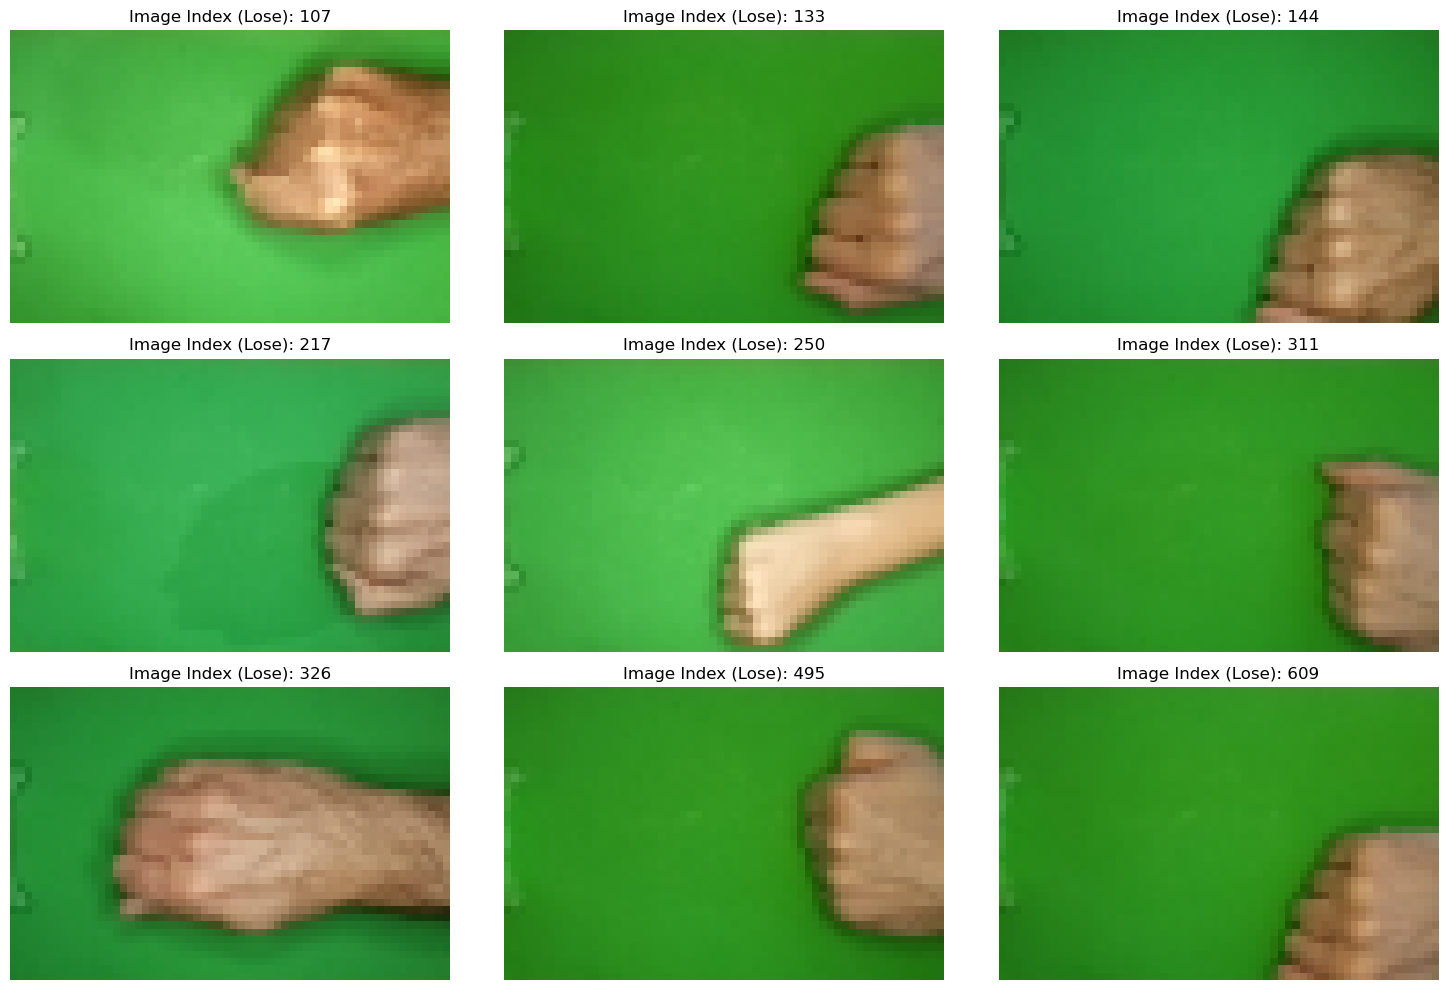

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(loses_idx):
        ax.imshow(x_test[loses_idx[i]], cmap='gray')
        ax.set_title(f"Image Index (Lose): {loses_idx[i]}")
        ax.axis('off')
    elif i - len(loses_idx) < len(ties_idx):
        ax.imshow(x_test[ties_idx[i - len(loses_idx)]], cmap='gray')
        ax.set_title(f"Image Index (Tie): {ties_idx[i - len(loses_idx)]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
dataset_extra = np.load('extra_rps_dataset.npz')
x_extra, y_extra = dataset_extra['images'], dataset_extra['labels']

In [14]:
wins_idx = []
ties_idx = []
loses_idx = []

for j in range(x_extra.shape[0]):
    action = agent.compute_single_action(RockPaperScissorsEnv.preprocess_image(x_extra[j], 0.5, 0.5))
    reward = RockPaperScissorsEnv.get_reward(action, y_extra[j])
    if reward == 1:
        wins_idx.append(j)
    elif reward == 0:
        ties_idx.append(j)
    elif reward == -1:
        loses_idx.append(j)

len(wins_idx), len(ties_idx), len(loses_idx)

(252, 258, 305)

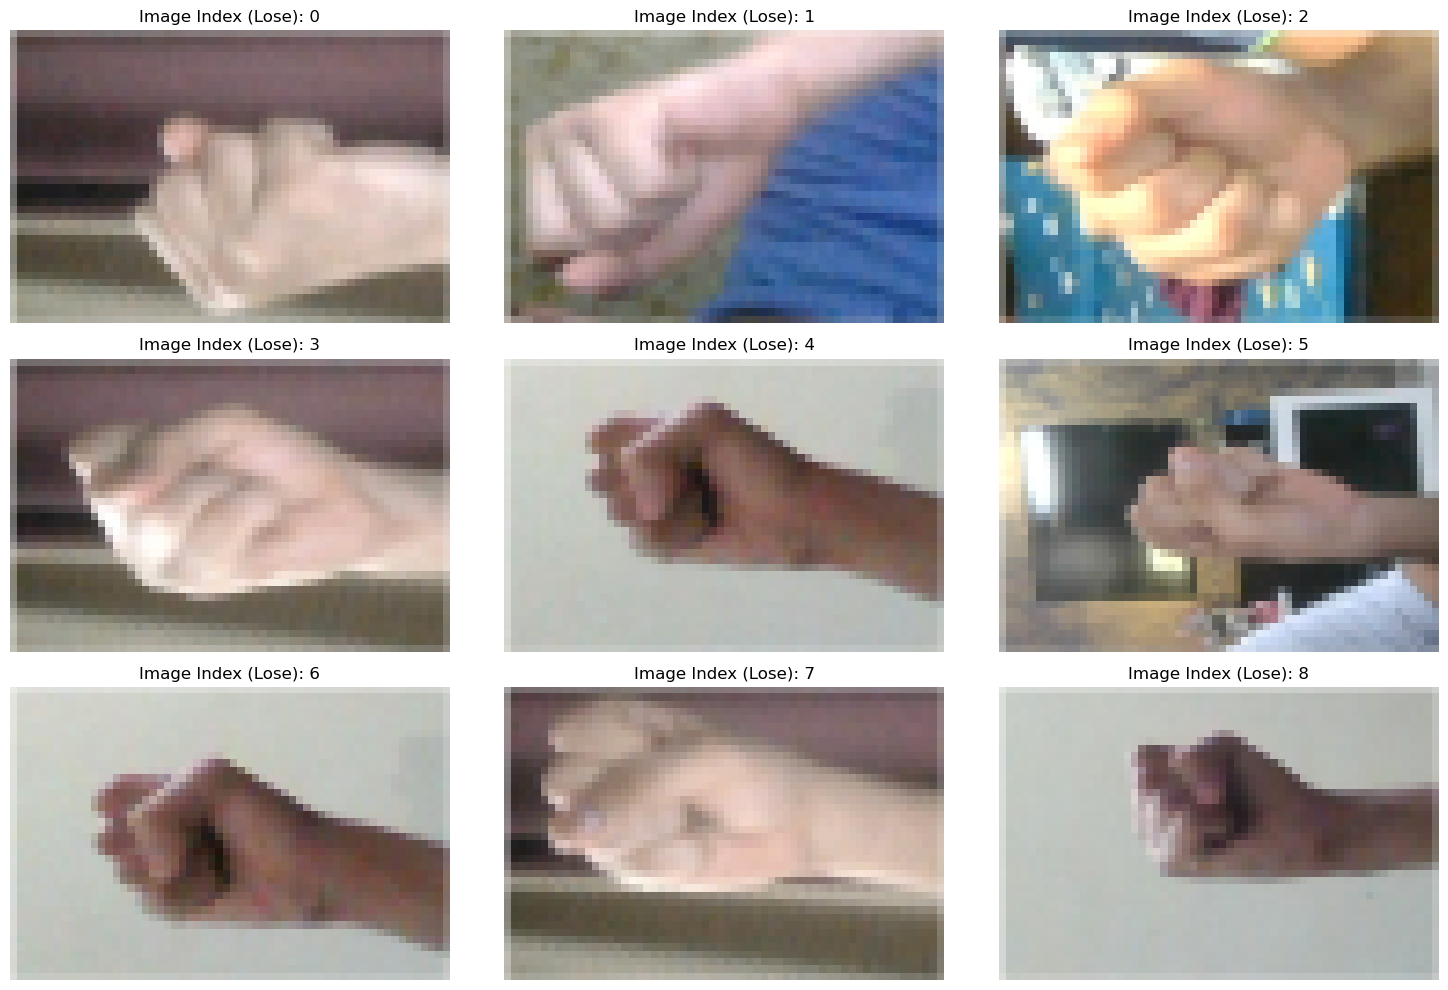

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(loses_idx):
        ax.imshow(x_extra[np.random.randint(low=0, high=len(loses_idx))], cmap='gray')
        ax.set_title(f"Image Index (Lose): {loses_idx[i]}")
        ax.axis('off')
    elif i - len(loses_idx) < len(ties_idx):
        ax.imshow(x_extra[ties_idx[i - len(loses_idx)]], cmap='gray')
        ax.set_title(f"Image Index (Tie): {ties_idx[i - len(loses_idx)]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((40, 60, 3,)),

    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.GaussianNoise(stddev=0.05),

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 40, 60, 3)         0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 40, 60, 3)        0         
 se)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 56, 64)        4864      
                                                                 
 average_pooling2d_2 (Averag  (None, 18, 28, 64)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_2 (Batc  (None, 18, 28, 64)       256       
 hNormalization)                                                 
                                                        

In [17]:
dataset = np.load('rps_dataset.npz')
x_train, y_train = dataset['x_train'], dataset['y_train']
x_test, y_test = dataset['x_test'], dataset['y_test']

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historyCNN = model.fit(x_train, y_train, batch_size=64, epochs=500, validation_data=(x_test, y_test))

Epoch 1/500
24/24 [==============================] - 10s 405ms/step - loss: 0.8140 - accuracy: 0.8210 - val_loss: 1.5611 - val_accuracy: 0.3166
Epoch 2/500
24/24 [==============================] - 5s 212ms/step - loss: 0.1079 - accuracy: 0.9706 - val_loss: 2.0561 - val_accuracy: 0.3105
Epoch 3/500
24/24 [==============================] - 5s 212ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 3.3143 - val_accuracy: 0.3105
Epoch 4/500
24/24 [==============================] - 5s 214ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 4.5670 - val_accuracy: 0.3105
Epoch 5/500
24/24 [==============================] - 5s 213ms/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 4.9766 - val_accuracy: 0.3105
Epoch 6/500
24/24 [==============================] - 5s 213ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 6.2422 - val_accuracy: 0.3105
Epoch 7/500
24/24 [==============================] - 5s 213ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 5.9068 - val_accuracy: 0.310

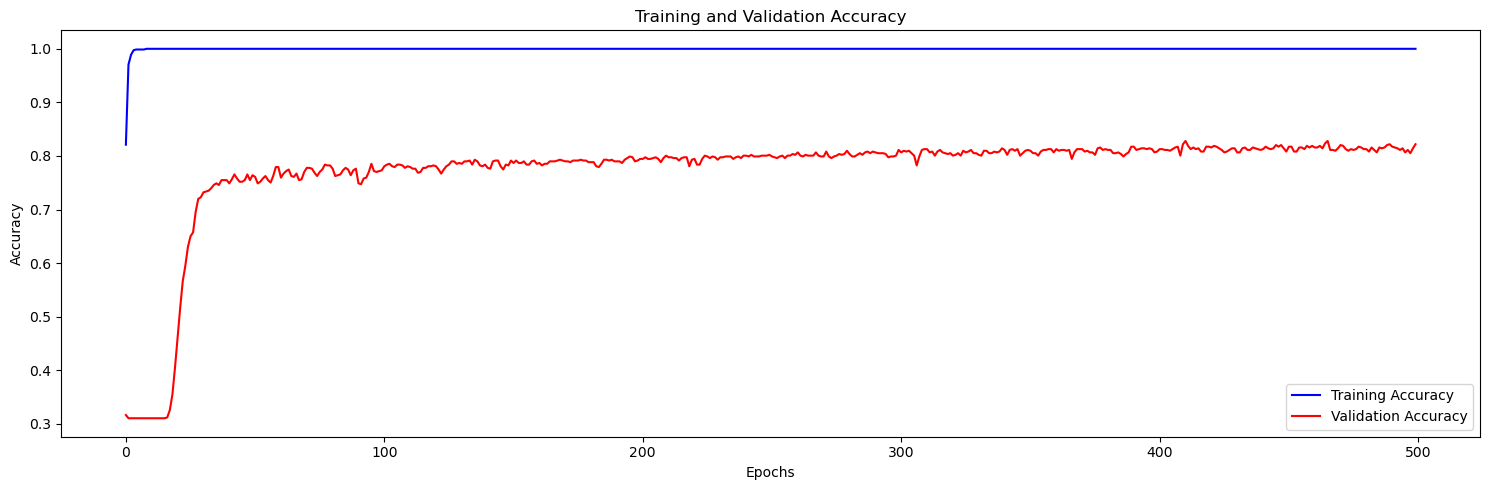

In [19]:
train_accuracy = historyCNN.history['accuracy']
val_accuracy = historyCNN.history['val_accuracy']

plt.figure(figsize=(15, 5))

# Plotting training and validation accuracy
plt.plot(train_accuracy, 'b-', label='Training Accuracy')
plt.plot(val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
def choose_gesture(predicted_gesture):
    if predicted_gesture == 0:
        return 1
    if predicted_gesture == 1:
        return 2
    if predicted_gesture == 2:
        return 0

In [21]:
ag_wins_idx = []
ag_ties_idx = []
ag_loses_idx = []
nn_wins_idx = []
nn_ties_idx = []
nn_loses_idx = []

for j in range(x_test.shape[0]):
    action = choose_gesture(np.argmax(model.predict(np.expand_dims(RockPaperScissorsEnv.preprocess_image(x_test[j], 0.5, 0.5), axis=0), verbose=0)))
    reward = RockPaperScissorsEnv.get_reward(action, y_test[j])
    if reward == 1:
        nn_wins_idx.append(j)
    elif reward == 0:
        nn_ties_idx.append(j)
    elif reward == -1:
        nn_loses_idx.append(j)
    action = agent.compute_single_action(RockPaperScissorsEnv.preprocess_image(x_test[j], 0.5, 0.5))
    reward = RockPaperScissorsEnv.get_reward(action, y_test[j])
    if reward == 1:
        ag_wins_idx.append(j)
    elif reward == 0:
        ag_ties_idx.append(j)
    elif reward == -1:
        ag_loses_idx.append(j)

print(f"Agent's Wins: {len(ag_wins_idx)}, Ties: {len(ag_ties_idx)}, Loses: {len(ag_loses_idx)}")
print(f"NN's Wins: {len(nn_wins_idx)}, Ties: {len(nn_ties_idx)}, Loses: {len(nn_loses_idx)}")

Agent's Wins: 639, Ties: 9, Loses: 9
NN's Wins: 591, Ties: 30, Loses: 36


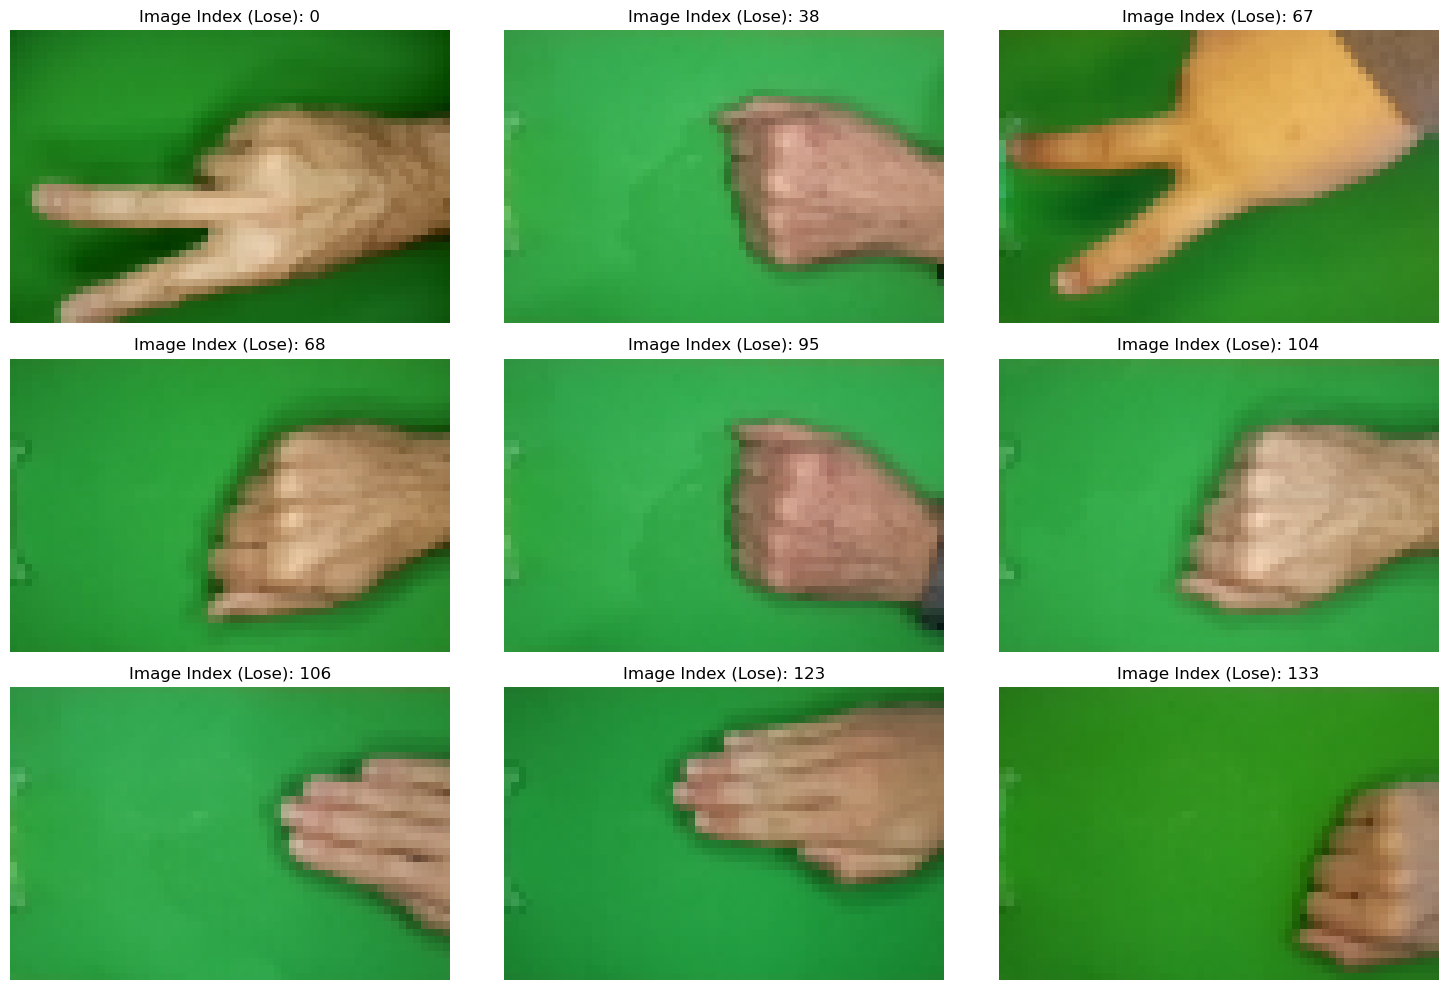

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(nn_loses_idx):
        ax.imshow(x_test[nn_loses_idx[i]], cmap='gray')
        ax.set_title(f"Image Index (Lose): {nn_loses_idx[i]}")
        ax.axis('off')
    elif i - len(nn_loses_idx) < len(nn_ties_idx):
        ax.imshow(x_test[nn_ties_idx[i - len(nn_loses_idx)]], cmap='gray')
        ax.set_title(f"Image Index (Tie): {nn_ties_idx[i - len(nn_loses_idx)]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
dataset_extra = np.load('extra_rps_dataset.npz')
x_extra, y_extra = dataset_extra['images'], dataset_extra['labels']

In [24]:
ag_wins_idx = []
ag_ties_idx = []
ag_loses_idx = []
nn_wins_idx = []
nn_ties_idx = []
nn_loses_idx = []

for j in range(x_extra.shape[0]):
    action = choose_gesture(np.argmax(model.predict(np.expand_dims(RockPaperScissorsEnv.preprocess_image(x_extra[j], 0.5, 0.5), axis=0), verbose=0)))
    reward = RockPaperScissorsEnv.get_reward(action, y_extra[j])
    if reward == 1:
        nn_wins_idx.append(j)
    elif reward == 0:
        nn_ties_idx.append(j)
    elif reward == -1:
        nn_loses_idx.append(j)
    action = agent.compute_single_action(RockPaperScissorsEnv.preprocess_image(x_extra[j], 0.5, 0.5))
    reward = RockPaperScissorsEnv.get_reward(action, y_extra[j])
    if reward == 1:
        ag_wins_idx.append(j)
    elif reward == 0:
        ag_ties_idx.append(j)
    elif reward == -1:
        ag_loses_idx.append(j)

print(f"Agent's Wins: {len(ag_wins_idx)}, Ties: {len(ag_ties_idx)}, Loses: {len(ag_loses_idx)}")
print(f"NN's Wins: {len(nn_wins_idx)}, Ties: {len(nn_ties_idx)}, Loses: {len(nn_loses_idx)}")

Agent's Wins: 252, Ties: 258, Loses: 305
NN's Wins: 270, Ties: 275, Loses: 270


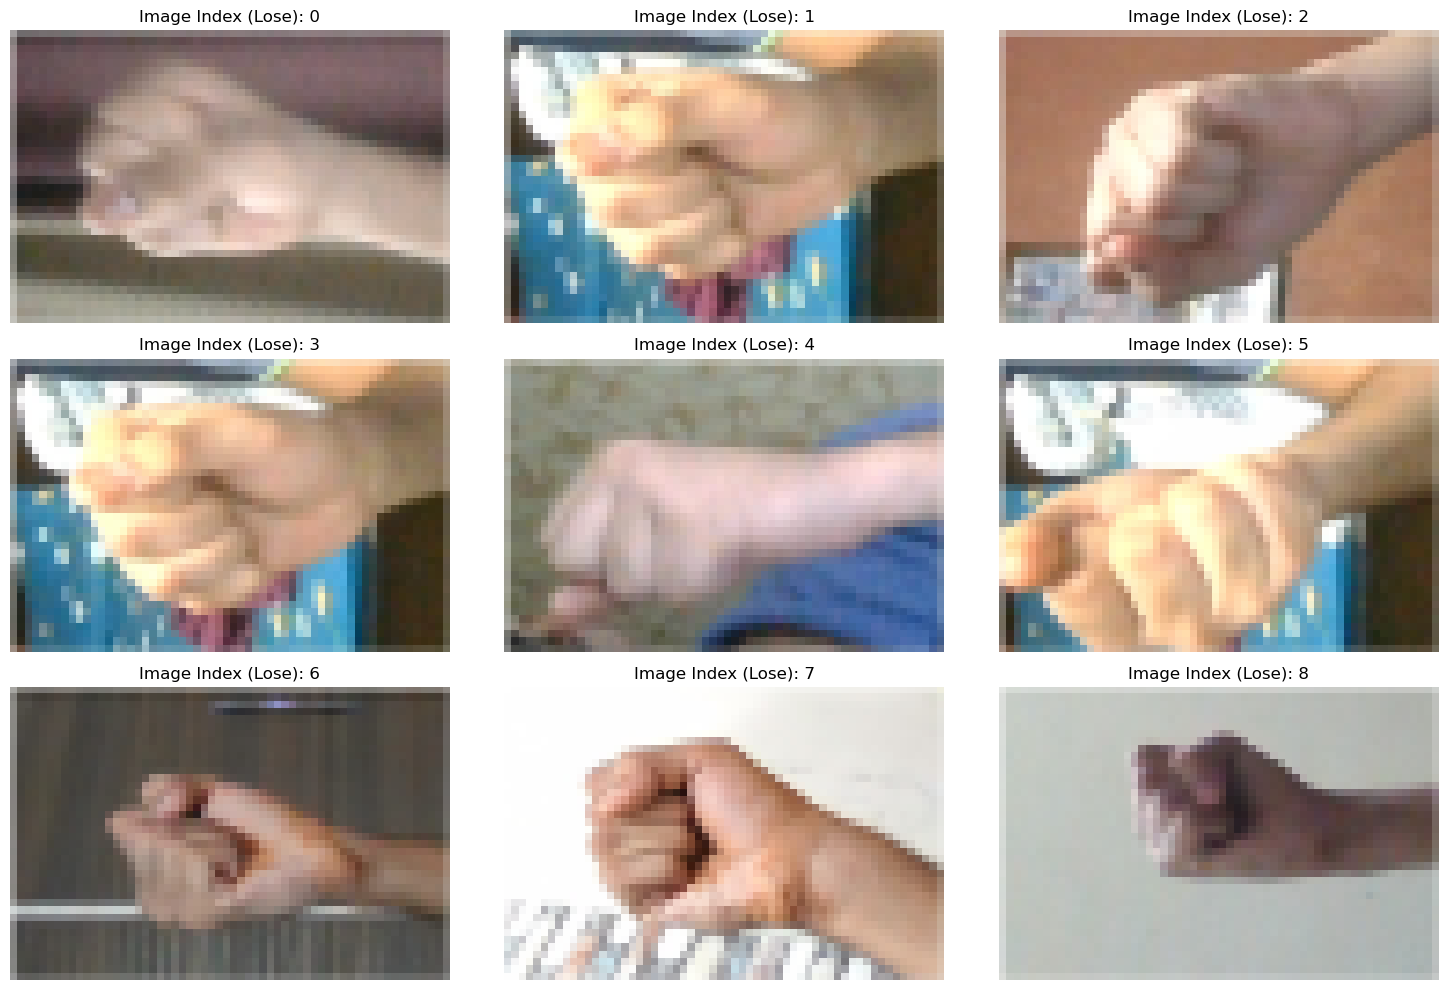

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(loses_idx):
        ax.imshow(x_extra[np.random.randint(low=0, high=len(loses_idx))], cmap='gray')
        ax.set_title(f"Image Index (Lose): {loses_idx[i]}")
        ax.axis('off')
    elif i - len(loses_idx) < len(ties_idx):
        ax.imshow(x_extra[ties_idx[i - len(loses_idx)]], cmap='gray')
        ax.set_title(f"Image Index (Tie): {ties_idx[i - len(loses_idx)]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()